## Autoencoders - [article](https://blog.keras.io/building-autoencoders-in-keras.html)

### Autoencoder examples - SImple, Deep and CNN



In [0]:
from keras.layers import Input, Dense
from keras.models import Model

#-------------------------------------------------------------------
# Build the simplest autoencoder model
# A single fully-connected neural layer as encoder and as decoder
#-------------------------------------------------------------------
def simple_autoencoder ():

  # this is the size of our encoded representations
  encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

  # this is our input placeholder
  input_img = Input(shape=(784,))
  # "encoded" is the encoded representation of the input
  encoded = Dense(encoding_dim, activation='relu')(input_img)
  # "decoded" is the lossy reconstruction of the input
  decoded = Dense(784, activation='sigmoid')(encoded)

  # this model maps an input to its reconstruction
  autoencoder = Model(input_img, decoded)

  # Configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:
  autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
  return autoencoder

#-------------------------------------------------------------------
# Prepare our MNIST input data, and we can discard the labels
#-------------------------------------------------------------------
from keras.datasets import mnist
import numpy as np
def prepare_data ():
  (x_train, _), (x_test, _) = mnist.load_data()

  # normalize all values between 0 and 1 and we will .
  x_train = x_train.astype('float32') / 255.
  x_test = x_test.astype('float32') / 255.

  # flatten the 28x28 images into vectors of size 784
  # 1st dim - no of samples, same as before. 
  # 2nd dim - multiply shape[1] * shape[2] ie. 28 x 28
  x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
  x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
  print (x_train.shape, x_test.shape)
  
  return (x_train, x_test)

#-------------------------------------------------------------------
# Train our autoencoder for 50 epochs to reconstruct MNIST digits.
#-------------------------------------------------------------------
def train_model (model, x_train, x_test, epochs, batch_size=256):
  model.fit(x_train, x_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  shuffle=True,
                  validation_data=(x_test, x_test))

autoencoder = simple_autoencoder ()
x_train, x_test = prepare_data()
train_model (autoencoder, x_train, x_test, epochs=50)

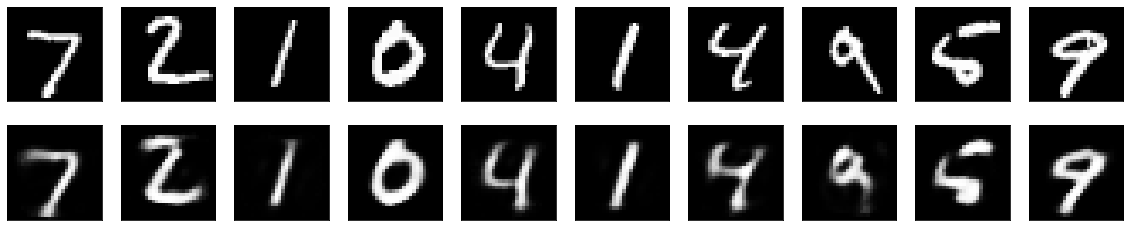

In [0]:
#-------------------------------------------------------------------
# Visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.
#-------------------------------------------------------------------
# use Matplotlib
import matplotlib.pyplot as plt
def show_output (orig_imgs, decoded_imgs, n):
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(orig_imgs[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(decoded_imgs[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()
  
n = 10  # how many digits we will display
decoded_imgs = autoencoder.predict (x_test)
show_output (x_test, decoded_imgs, n)

#-------------------------------------------------------------------
# For some reason, in the tutorial, they create separate models for the encoder
# and decoder. Not sure why, because it produces the same results
#-------------------------------------------------------------------
def tut_separate_model ():
  # Create a separate encoder model, that maps an input to its encoded representation
  encoder = Model(input_img, encoded)

  # As well as the decoder model. Create a placeholder for an encoded (32-dimensional) input
  encoded_input = Input(shape=(encoding_dim,))
  # retrieve the last layer of the autoencoder model
  decoder_layer = autoencoder.layers[-1]
  # create the decoder model
  decoder = Model(encoded_input, decoder_layer(encoded_input))

  # encode and decode some digits, from the *test* set
  encoded_imgs = encoder.predict(x_test)
  decoded_imgs = decoder.predict(encoded_imgs)

  show_output (x_test, decoded_imgs, n)

In [0]:
#-------------------------------------------------------------------
# Add a sparsity constraint on the encoded representations
# In the previous example, the representations were only constrained by the size of the hidden 
# layer (32). In such a situation, what typically happens is that the hidden layer is learning 
# an approximation of PCA (principal component analysis). But another way to constrain the 
# representations to be compact is to add a sparsity contraint on the activity of the hidden 
# representations, so fewer units would "fire" at a given time. In Keras, this can be done 
# by adding an activity_regularizer to our Dense layer
#-------------------------------------------------------------------
from keras import regularizers

def sparsity_autoencoder ():
  encoding_dim = 32

  input_img = Input(shape=(784,))
  # add a Dense layer with a L1 activity regularizer
  encoded = Dense(encoding_dim, activation='relu',
                  activity_regularizer=regularizers.l1(10e-5))(input_img)
  decoded = Dense(784, activation='sigmoid')(encoded)

  sparsity = Model(input_img, decoded)
  
  # Configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:
  sparsity.compile(optimizer='adadelta', loss='binary_crossentropy')
  
  return (sparsity)

# train this model for 100 epochs (with the added regularization the model is less likely to overfit 
# and can be trained longer). The outputs look pretty similar to the previous model, the only significant 
# difference being the sparsity of the encoded representations, which are now twice as sparse
sparsity = sparsity_autoencoder()
train_model (sparsity, x_train, x_test, epochs=100)
decoded_imgs = sparsity.predict (x_test)
show_output (x_test, decoded_imgs, n)

In [0]:
#-------------------------------------------------------------------
# Deep autoencoder - We have multiple layers for the encoder or decoder
#-------------------------------------------------------------------
def deep_autoencoder (): 
  input_img = Input(shape=(784,))
  encoded = Dense(128, activation='relu')(input_img)
  encoded = Dense(64, activation='relu')(encoded)
  encoded = Dense(32, activation='relu')(encoded)

  decoded = Dense(64, activation='relu')(encoded)
  decoded = Dense(128, activation='relu')(decoded)
  decoded = Dense(784, activation='sigmoid')(decoded)

  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
  
  return (autoencoder)

deep = deep_autoencoder()
train_model (deep, x_train, x_test, epochs=100)
decoded_imgs = deep.predict (x_test)
show_output (x_test, decoded_imgs, n)

In [0]:
#-------------------------------------------------------------------
# Convolutional autoencoder - since our input is images, use CNNs as encoders and decoders as they simply perform much better.
# The encoder will consist of a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), 
# while the decoder will consist in a stack of Conv2D and UpSampling2D layers.
#-------------------------------------------------------------------
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
def cnn_autoencoder (): 
  input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

  x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same')(x)

  # at this point the representation is (4, 4, 8) i.e. 128-dimensional

  x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(16, (3, 3), activation='relu')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')  
  return (autoencoder)

#-------------------------------------------------------------------
# The input image shape to the CNN is different as it is not flattened. shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1
#-------------------------------------------------------------------
def prepare_cnn_data ():
  (x_train, _), (x_test, _) = mnist.load_data()

  # normalize all values between 0 and 1
  x_train = x_train.astype('float32') / 255.
  x_test = x_test.astype('float32') / 255.
  
  # MNIST data has shape (samples, 3, 28, 28)
  x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
  x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
  print (x_train.shape, x_test.shape)
  
  return (x_train, x_test)

cnn = cnn_autoencoder()
x_train, x_test = prepare_cnn_data ()
train_model (cnn, x_train, x_test, epochs=50, batch_size=128)
decoded_imgs = cnn.predict (x_test)
show_output (x_test, decoded_imgs, n)

### Use a CNN Autoencoder for Image Denoising

In [0]:
# Use the CNN autoencoder to remove noise from images
# Train the autoencoder to map noisy digits images to clean digits images.

#-------------------------------------------------------------------
# Compared to the previous CNN autoencoder, in order to improve the quality of the reconstructed, 
# we'll use a slightly different model with more filters per layer
#-------------------------------------------------------------------
def cnn_denoise_autoencoder (): 
  input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

  x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same')(x)

  # at this point the representation is (7, 7, 32)

  x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
  return (autoencoder)
  
#-------------------------------------------------------------------
# Train our autoencoder for 50 epochs to reconstruct MNIST digits.
#-------------------------------------------------------------------
def train_denoise_model (model, x_train, x_train_noisy, x_test, x_test_noisy, epochs, batch_size=256):
  model.fit(x_train_noisy, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))
  
#-------------------------------------------------------------------
# Generate synthetic noisy digits - apply a gaussian noise matrix and clip the images between 0 and 1.
#-------------------------------------------------------------------
def prepare_noisy_data (x_train, x_test):
  noise_factor = 0.5
  x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
  x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

  x_train_noisy = np.clip(x_train_noisy, 0., 1.)
  x_test_noisy = np.clip(x_test_noisy, 0., 1.)

  return (x_train_noisy, x_test_noisy)

cnn_denoise = cnn_denoise_autoencoder()
x_train, x_test = prepare_cnn_data ()
x_train_noisy, x_test_noisy = prepare_noisy_data(x_train, x_test)
train_denoise_model (cnn_denoise, x_train, x_train_noisy, x_test, x_test_noisy, epochs=100, batch_size=128)

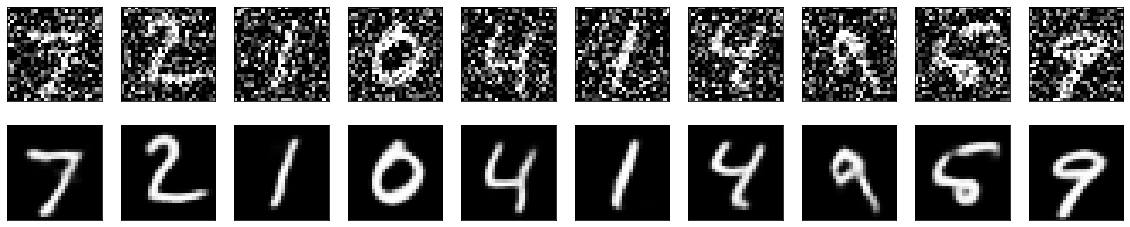

In [0]:
decoded_imgs = cnn_denoise.predict (x_test_noisy)
show_output (x_test_noisy, decoded_imgs, n)

### Sequence-to-Sequence Autoencoder

### Variational Autoencoder

(60000, 784) (10000, 784)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_4[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_4[0][0]                    
___________________________________________________________________________________

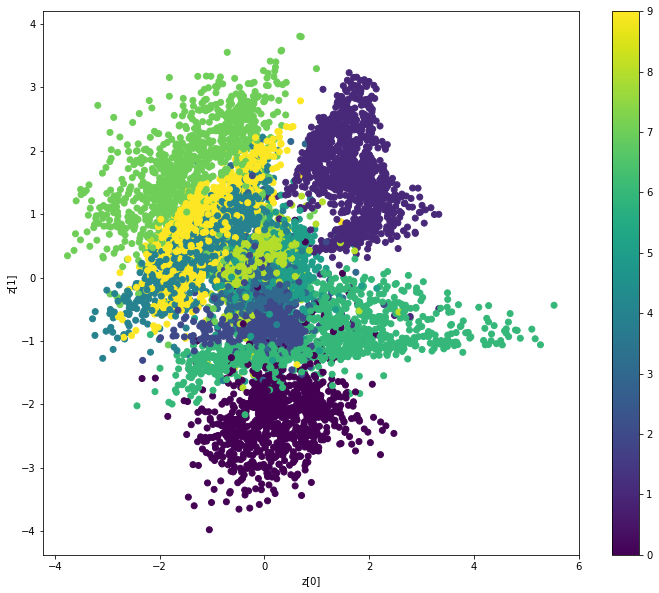

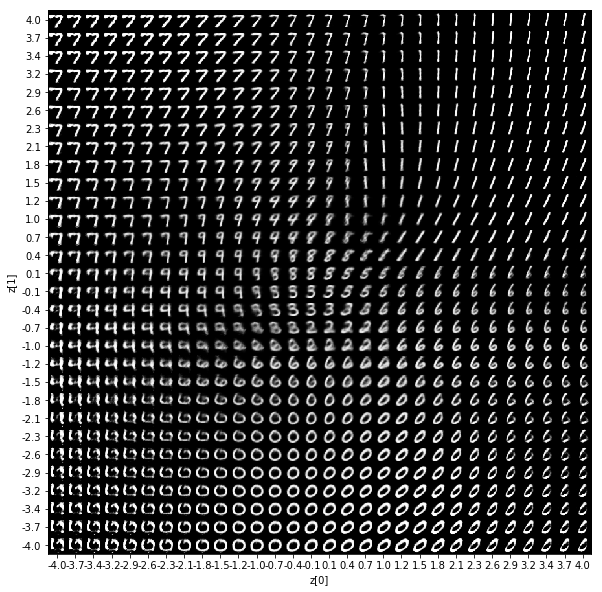

In [15]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
from IPython.display import Image

# -------------------------------------------------------
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
# ------------------------------------
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0] # shape() returns shape as a tensor
    dim = K.int_shape(z_mean)[1] # int_shape() returns shape as a tuple
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
  
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()
    
#-----------------------------------------------
# Load MNIST data
#-----------------------------------------------
def prepare_vae_data ():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()

  # normalize all values between 0 and 1 and we will .
  x_train = x_train.astype('float32') / 255.
  x_test = x_test.astype('float32') / 255.

  # flatten the 28x28 images into vectors of size 784
  # 1st dim - no of samples, same as before. 
  # 2nd dim - multiply shape[1] * shape[1] ie. 28 x 28
  image_size = x_train.shape[1]
  original_dim = image_size * image_size
  x_train = np.reshape(x_train, [-1, original_dim])
  x_test = np.reshape(x_test, [-1, original_dim])
  print (x_train.shape, x_test.shape)
  
  return (x_train, x_test, y_train, y_test, original_dim)

#-----------------------------------------------
# Define a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.
#-----------------------------------------------
def loss_func (inputs, outputs, original_dim, z_mean, z_log_var):
  reconstruction_loss = binary_crossentropy(inputs, outputs)
  reconstruction_loss *= original_dim
  kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  vae_loss = K.mean(reconstruction_loss + kl_loss)
  
  return (vae_loss)

#-----------------------------------------------
# Build the model - instantiate 3 models that share weights:
#
#    1) a VAE end-to-end autoencoder mapping inputs to reconstructions, which we train
#    2) an encoder that maps inputs to the latent space
#    3) a decoder that can take points on the latent space and will output the corresponding reconstructed samples
#-----------------------------------------------
def build_model (input_shape, intermediate_dim, latent_dim):
  # VAE model = encoder + decoder
  # build encoder model
  inputs = Input(shape=input_shape, name='encoder_input')
  x = Dense(intermediate_dim, activation='relu')(inputs)
  z_mean = Dense(latent_dim, name='z_mean')(x)
  z_log_var = Dense(latent_dim, name='z_log_var')(x)
  
  # use reparameterization trick to push the sampling out as input
  z = Lambda(sampling, name='z')([z_mean, z_log_var])
  
  # instantiate encoder model
  encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
  encoder.summary()
  plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
  Image(filename='vae_mlp_encoder.png')
  
  # build decoder model
  latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
  x = Dense(intermediate_dim, activation='relu')(latent_inputs)
  outputs = Dense(original_dim, activation='sigmoid')(x)
  
  # instantiate decoder model
  decoder = Model(latent_inputs, outputs, name='decoder')
  decoder.summary()
  plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)
  Image(filename='vae_mlp_decoder.png')
  
  # instantiate VAE model
  outputs = decoder(encoder(inputs)[2])
  vae = Model(inputs, outputs, name='vae_mlp')
  
  vae_loss = loss_func (inputs, outputs, original_dim, z_mean, z_log_var)
  vae.add_loss(vae_loss)
  vae.compile(optimizer='adam')
    
  vae.summary()
  plot_model(vae, to_file='vae_mlp.png', show_shapes=True)
  Image(filename='vae_mlp.png')
  
  return (vae, encoder, decoder)

x_train, x_test, y_train, y_test, original_dim = prepare_vae_data()
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

vae, encoder, decoder = build_model (input_shape, intermediate_dim, latent_dim)
vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
models = (encoder, decoder)
data = (x_test, y_test)
plot_results(models, data, batch_size=batch_size, model_name="vae_mlp")